# Classification of Target Position based on Ancillary Measurements
### *Identifying our targets by what they "sound" like*

by: Bryan Dannowitz

### Problem:
Our proton beam shoots at our *target table*. The table shifts back and forth, allowing us to hit one of seven targets. For a certain range of data, we're not 100% sure what our target position was. We want to be certain before we analyze it.

### Objective:
We have many (90+) readouts of esoteric measures like *trigger rates* and radiation levels. Here, I aggregate these readouts, exclude non-useful *features*, and train a *Random Forest Classifier* to predict our target position.

### Notes:
* SpillID range: 416709 to 423211
* RunID range: 11350 to 11468

### Procedure:
1. Get a full readout of *features* from our MySQL storage
2. Clean it up by removing entries from 'bad spills'
3. Exclude any non-helpful *features*
4. Train and test an RFC
5. Pickle it for daily use at our experiment

In [2]:
from os import path, remove         # Check if files exist
import pymysql as mdb               # Raw data source is MySQL
import pandas as pd                 # Workhorse data management tool
import numpy as np                  # For matrices, arrays, matrix math, and nan's
from math import floor

## Notebook Specifics

In [3]:
%matplotlib inline           
pd.set_option("max_rows", 10)
np.set_printoptions(precision=3)       

## Plotting, Graphics

In [4]:
import matplotlib.pyplot as plt     # For plotting some distributions
import seaborn as sns               # For easy, pretty plotting
sns.set_style("darkgrid")
sns.set_context("talk", font_scale=1.4)

# Wrangling the data into shape

## Reading Data from MySQL

In [4]:
server = 'e906-db3.fnal.gov'                         # Source MySQL server
port = 3306
schema = 'merged_roadset62_R005_V001'                # Source MySQL schema
analysis_schema = 'user_dannowitz_target_analysis'   # A schema name for temporary storage
analysis_table = 'target_analysis_feb16'             # A table name for that schema

In [181]:
# Aggregate data into our analysis schema and table.
# Table defined here:
spill_range = "spillID BETWEEN 394308 AND 416700 OR spillID BETWEEN 425000 AND 443000"
query = """
SELECT spillID, name, value, targetPos 
   FROM Beam b INNER JOIN Spill s USING(spillID) 
   WHERE s.dataQuality = 0 AND 
         (%s) AND
         name IS NOT NULL
UNION
SELECT spillID, scalerName as `name`, value, targetPos 
   FROM Scaler b INNER JOIN Spill s USING(spillID) 
   WHERE s.dataQuality = 0 AND 
         (%s) AND
         spillType = "EOS" AND
         scalerName IS NOT NULL
       """ % (spill_range, spill_range)

In [182]:
# Run the query and read the resultset into a DataFrame
try:
    db = mdb.connect(read_default_file='../.my.cnf',                  # Keep my login credentials secure
                     read_default_group='guest',                   # Read-only access to important data
                     host=server,
                     db=schema,
                     port=port)
    
    df = pd.read_sql(query, db)

    if db:
        db.close()

except mdb.Error, e:

    print "Error %d: %s" % (e.args[0], e.args[1])

In [183]:
df.head()

,spillID,name,value,targetPos
0,435610,F:NS2FLO,222.69375,1
1,435610,F:NS2SUP,79.6806640625,1
2,435610,F:NS2RET,86.3713378906,1
3,435610,F:NM2V,0.799560546875,1
4,435610,F:NM2D1,720.596313477,1


In [184]:
# Write to file, and you can read it back instead of querying again
df.to_csv('insight_demo_roadset62_long.csv')

In [107]:
# Write to file, and you can read it back instead of querying again
df = pd.read_csv('insight_demo_roadset62_long.csv', index_col='Unnamed: 0')

In [185]:
df.info()                # ...and investigate data types.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504224 entries, 0 to 1504223
Data columns (total 4 columns):
spillID      1504224 non-null int64
name         1504224 non-null object
value        1504224 non-null object
targetPos    1504224 non-null int64
dtypes: int64(2), object(2)
memory usage: 57.4+ MB


In [186]:
df.value = df.value.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504224 entries, 0 to 1504223
Data columns (total 4 columns):
spillID      1504224 non-null int64
name         1504224 non-null object
value        1504224 non-null float64
targetPos    1504224 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 57.4+ MB


## Clean the Data some more
### *Feature Exclusion*

1. Pivot the dataframe
2. Eliminate rows with missing data
3. Inspect the means and standard deviations
4. Identify the *zero standard deviation* features, as they're not helpful
5. Remove them from our pivoted dataframe and our scaler_df dataset

In [187]:
# Let's prepare the lables, or, our target positions
targpos_df = (df[['spillID','targetPos']].drop_duplicates()
                                         .sort_values(by='spillID')
                                         .set_index('spillID', drop=True))
targpos_df.head()

,targetPos
spillID,
414558,3
414559,3
414560,3
414564,7
414565,6


In [188]:
# We want to see our names as column indexes
pivoted_df = df.pivot('spillID', 'name', 'value'); pivoted_df.head()

name,AcceptedBOS,AcceptedEOS,AcceptedMATRIX1,AcceptedMATRIX2,AcceptedMATRIX3,AcceptedMATRIX4,AcceptedMATRIX5,AcceptedNIM1,AcceptedNIM2,AcceptedNIM3,...,RawMATRIX5,RawNIM1,RawNIM2,RawTriggers,S:F1SEM,S:G2SEM,S:KTEVTC,S:MSEP1U,TSGo,TsBusy
spillID,,,,,,,,,,,,,,,,,,,,,
414558,0,1,1220,171,11,11,9,25,0,20,...,254966,1508561,6120639,8205416,287337330,3.596068e+12,0.009769,433.234375,1466,1467
414559,0,1,1292,171,11,13,10,27,0,17,...,258295,1556812,6419139,8605031,317439336,3.911382e+12,0.010367,433.218750,1540,1541
414560,0,1,1422,162,12,14,12,25,0,19,...,251242,1694833,6955674,9171027,353014434,3.803889e+12,0.010556,433.218750,1666,1667
414564,0,1,893,195,8,10,7,17,0,20,...,275644,1379114,5216881,7351291,287337330,3.793076e+12,0.010556,433.171875,1148,1149
414565,0,1,983,159,8,11,8,24,0,20,...,240187,1483687,5791524,7869077,306493152,3.821238e+12,0.010747,433.140625,1212,1213


In [189]:
# Don't need this anymore
del df

### Handle (remove) missing data

In [190]:
pivoted_df = pivoted_df.replace(-9999,np.nan).dropna(axis=1)

### Identify *zero standard deviation* features

In [191]:
# It's sufficient to say that if the standard deviation is 0, then it's certainly not useful
zero_std_series = (pivoted_df.describe().ix['std'] == 0)
# Get an array of all the features with zero standard deviations
zero_std_features = zero_std_series[zero_std_series == True].index.values; zero_std_features

array(['AcceptedBOS', 'AcceptedEOS', 'AcceptedNIM2', 'AcceptedNIM4',
       'AcceptedNIM5', 'E:M3TGHF', 'E:M3TGHI', 'E:M3TGVF', 'E:M3TGVI',
       'F:NM3ION', 'G:BNCH13', 'G:NBSYD', 'NM3SEM', 'PrescaleNIM2',
       'PrescaleNIM4', 'PrescaleNIM5', 'PrescaledBOS', 'PrescaledEOS'], dtype=object)

### Remove these from our analysis

In [192]:
# Get rid of these features
_ = pivoted_df.drop(zero_std_features, axis=1, inplace=True)

# Assemble Cleaned, Processed Data
### With data and labels, so that it's well-suited to be fed to our RFC

### Merge the data with the labels

In [193]:
full_df = pd.merge(pivoted_df, targpos_df, left_index=True, right_index=True)
full_df.head()

name,AcceptedMATRIX1,AcceptedMATRIX2,AcceptedMATRIX3,AcceptedMATRIX4,AcceptedMATRIX5,AcceptedNIM1,AcceptedNIM3,AfterInhMATRIX1,AfterInhMATRIX2,AfterInhMATRIX3,...,RawNIM1,RawNIM2,RawTriggers,S:F1SEM,S:G2SEM,S:KTEVTC,S:MSEP1U,TSGo,TsBusy,targetPos
spillID,,,,,,,,,,,,,,,,,,,,,
414558,1220,171,11,11,9,25,20,1222,204476,1337,...,1508561,6120639,8205416,287337330,3.596068e+12,0.009769,433.234375,1466,1467,3
414559,1292,171,11,13,10,27,17,1292,207447,1340,...,1556812,6419139,8605031,317439336,3.911382e+12,0.010367,433.218750,1540,1541,3
414560,1422,162,12,14,12,25,19,1422,191993,1442,...,1694833,6955674,9171027,353014434,3.803889e+12,0.010556,433.218750,1666,1667,3
414564,893,195,8,10,7,17,20,892,235324,1020,...,1379114,5216881,7351291,287337330,3.793076e+12,0.010556,433.171875,1148,1149,7
414565,983,159,8,11,8,24,20,982,189941,1039,...,1483687,5791524,7869077,306493152,3.821238e+12,0.010747,433.140625,1212,1213,6


In [194]:
# Write it to file for use in the next part.
full_df.to_csv('roadset62_targetPos_study.csv')

In [5]:
full_df = pd.read_csv('roadset62_targetPos_study.csv', index_col='spillID')

IOError: File roadset62_targetPos_study.csv does not exist

In [482]:
all_df = pd.read_csv('roadset62_targetPos_study.csv', index_col='spillID')
all_df = all_df[all_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 6).all(axis=1)]
all_df['liveProton'] = proton_df.liveProton
all_df['dutyFactor'] = dutyfactor_df.dutyFactor
all_df.sort_values('targetPos', inplace=True)

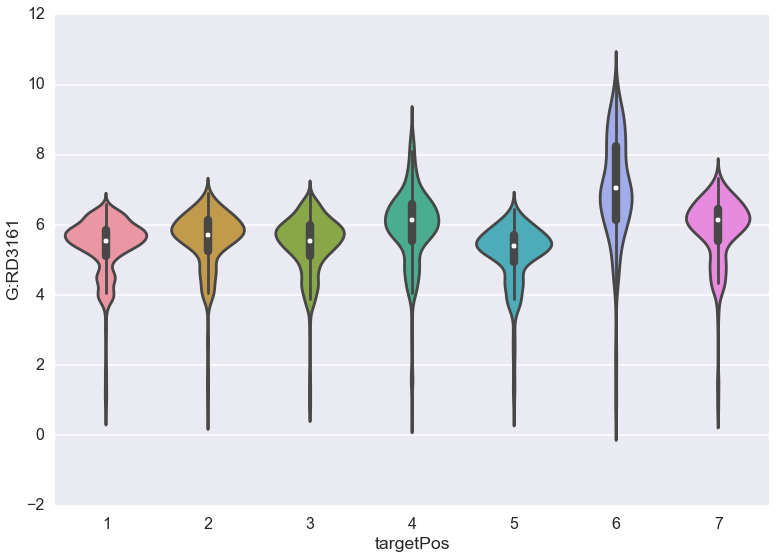

In [484]:
sns.violinplot(x=all_df.targetPos, y=all_df['G:RD3161'])

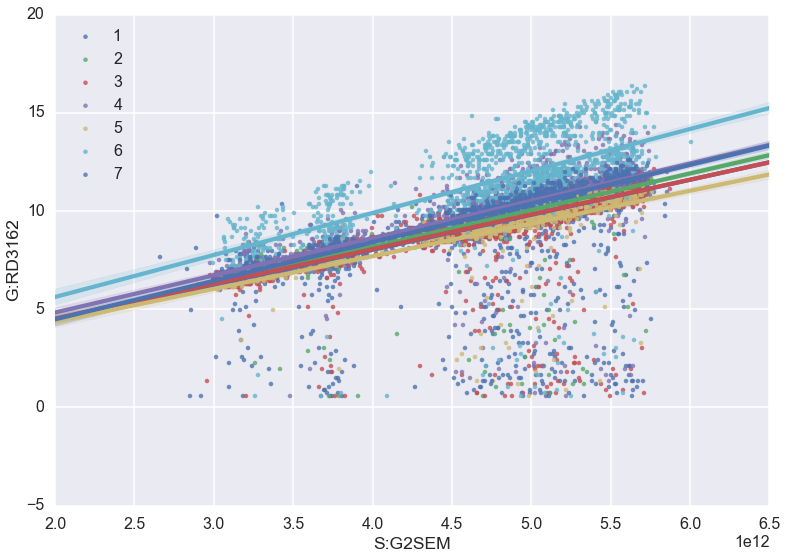

In [487]:
#ax = sns.regplot(all_df.query('targetPos==1')['S:G2SEM'],
#                 all_df.query('targetPos==1')['G:RD3161'],
#                 label="1")
for target in range(1,8):
    sns.regplot(all_df.query('targetPos==@target')['S:G2SEM'],
                all_df.query('targetPos==@target')['G:RD3162'],
                label="%d" % target)
plt.legend(loc='best')

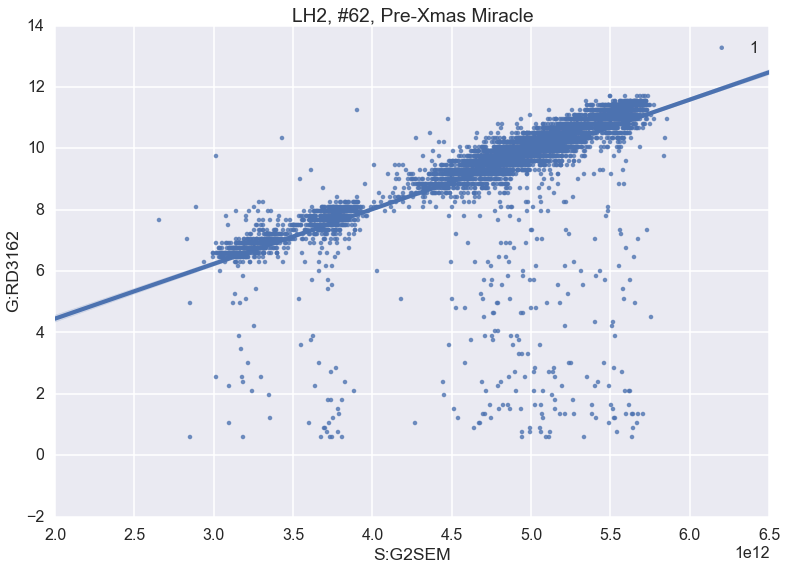

In [485]:
sns.regplot(all_df.query('targetPos==1')['S:G2SEM'],
            all_df.query('targetPos==1')['G:RD3162'],
            label="1")
plt.title("LH2, #62, Pre-Xmas Miracle")
plt.legend(loc='best')

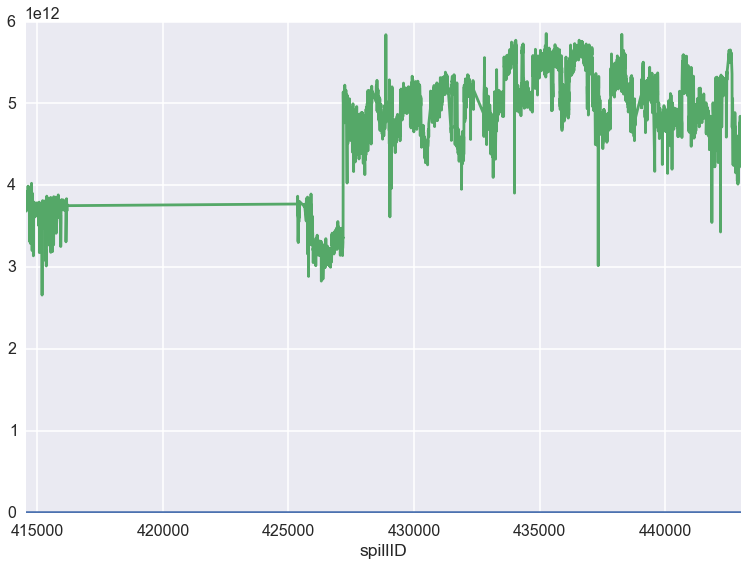

In [492]:
all_df.query('targetPos==1')['G:RD3161'].sort_index().plot()
all_df.query('targetPos==1')['S:G2SEM'].sort_index().plot()

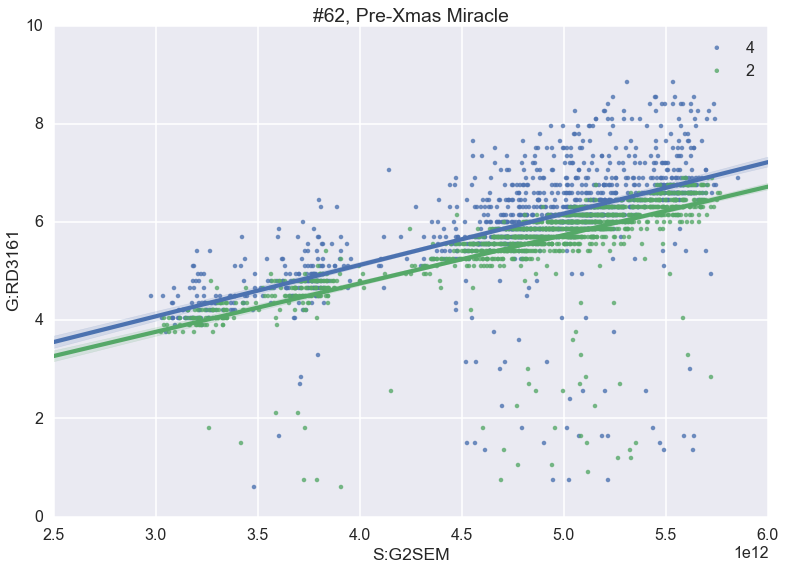

In [489]:
sns.regplot(all_df.query('targetPos==4')['S:G2SEM'],
            all_df.query('targetPos==4')['G:RD3161'],
            label="4")
sns.regplot(all_df.query('targetPos==2')['S:G2SEM'],
            all_df.query('targetPos==2')['G:RD3161'],
            label="2")
plt.title("#62, Pre-Xmas Miracle")
plt.legend(loc='best')

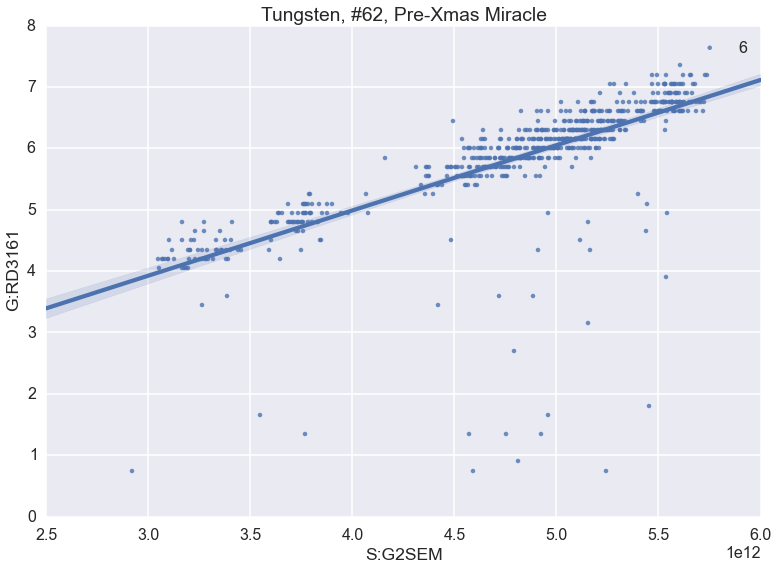

In [481]:
sns.regplot(all_df.query('targetPos==7')['S:G2SEM'],
            all_df.query('targetPos==7')['G:RD3161'],
            label="7")
plt.title("Tungsten, #62, Pre-Xmas Miracle")
plt.legend(loc='best')

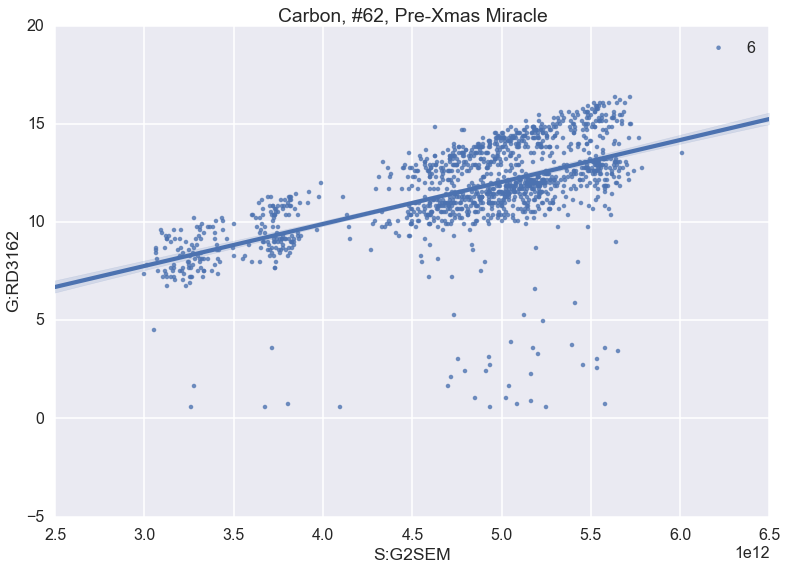

In [486]:
sns.regplot(all_df.query('targetPos==6')['S:G2SEM'],
            all_df.query('targetPos==6')['G:RD3162'],
            label="6")
plt.title("Carbon, #62, Pre-Xmas Miracle")
plt.legend(loc='best')

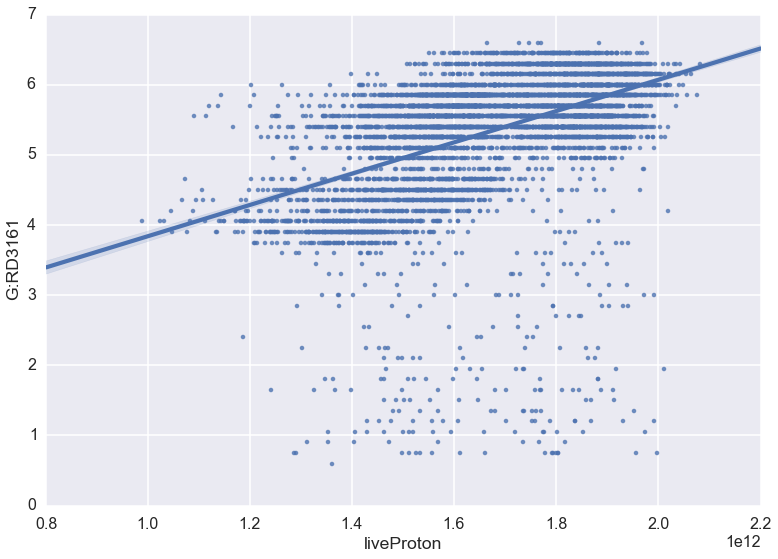

In [456]:
sns.regplot(all_df.query('targetPos==1')['liveProton'], all_df.query('targetPos==1')['G:RD3161'])

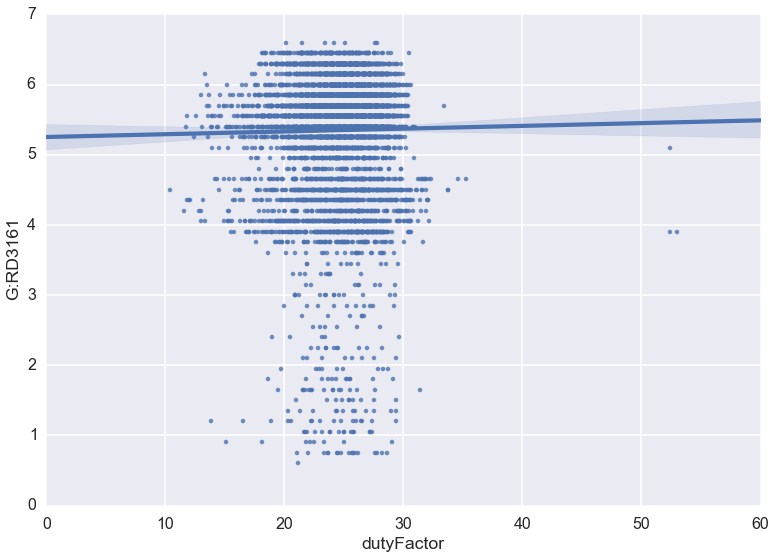

In [457]:
sns.regplot(all_df.query('targetPos==1')['dutyFactor'], all_df.query('targetPos==1')['G:RD3161'])

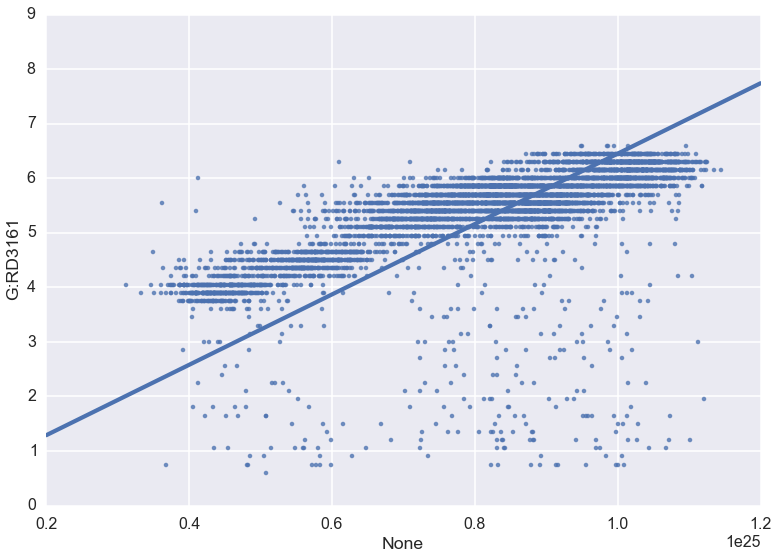

In [461]:
sns.regplot(all_df.query('targetPos==1')['S:G2SEM']*all_df.query('targetPos==1')['liveProton'], all_df.query('targetPos==1')['G:RD3161'])

## Feature Engineering
* One thing we do know in this experiment is that *'S:G2SEM'* is a measure of ***Beam Intensity***
* ***Beam Intensity*** does not depend on anything in our experiment...
* BUT many, *many* things in our experiment depend on *Beam Intensity*
* So, normalize all *features* to ***Beam Intensity*** for more robust classifier

In [323]:
# Rescale the training data to beam intensity
#    Beam intensity is a big number (~10^12), so multiply by a big constant
#    to bring it back up to normal feature ranges 
full_df = pd.concat([(full_df.drop('targetPos', axis=1)
                             .divide(full_df['S:G2SEM']/5.0e12, axis=0)),
                     full_df.targetPos],
                    axis=1)
_ = full_df.drop('S:G2SEM', axis=1, inplace=True)

In [125]:
query = ("SELECT spillID, liveProton FROM Spill WHERE dataQuality=0 AND (%s)" % spill_range)
try:
    db = mdb.connect(read_default_file='../.my.cnf',                  # Keep my login credentials secure
                     read_default_group='guest',                   # Read-only access to important data
                     host=server,
                     db=schema,
                     port=port)
    
    proton_df = pd.read_sql(query, db, index_col='spillID')

    if db:
        db.close()

except mdb.Error, e:

    print "Error %d: %s" % (e.args[0], e.args[1])

In [238]:
# Rescale the training data to beam intensity
#    Beam intensity is a big number (~10^12), so multiply by a big constant
#    to bring it back up to normal feature ranges 
full_df = pd.concat([(full_df.drop('targetPos', axis=1)
                             .divide(proton_df.liveProton/2e12, axis=0)),
                     full_df.targetPos],
                    axis=1)
#_ = full_df.drop('S:G2SEM', axis=1, inplace=True)

In [131]:
query = ("""SELECT spillID, dutyfactor53MHz AS `dutyFactor` 
            FROM BeamDAQ INNER JOIN Spill USING(spillID) 
            WHERE (%s) AND dataQuality=0""" % spill_range)
try:
    db = mdb.connect(read_default_file='../.my.cnf',                  # Keep my login credentials secure
                     read_default_group='guest',                   # Read-only access to important data
                     host=server,
                     db=schema,
                     port=port)
    
    dutyfactor_df = pd.read_sql(query, db, index_col='spillID')

    if db:
        db.close()

except mdb.Error, e:

    print "Error %d: %s" % (e.args[0], e.args[1])

In [196]:
# Rescale the training data to beam intensity
#    Beam intensity is a big number (~10^12), so multiply by a big constant
#    to bring it back up to normal feature ranges 
full_df = pd.concat([(full_df.drop('targetPos', axis=1)
                             .divide(dutyfactor_df.dutyFactor/30.0, axis=0)),
                     full_df.targetPos],
                    axis=1)
#_ = full_df.drop('S:G2SEM', axis=1, inplace=True)

In [210]:
combo_df = (proton_df.liveProton * dutyfactor_df.dutyFactor) / (30.0 * 2.0e12)

In [211]:
# Rescale the training data to beam intensity
#    Beam intensity is a big number (~10^12), so multiply by a big constant
#    to bring it back up to normal feature ranges 
full_df = pd.concat([(full_df.drop('targetPos', axis=1)
                             .divide(combo_df, axis=0)),
                     full_df.targetPos],
                    axis=1)
#_ = full_df.drop('S:G2SEM', axis=1, inplace=True)

# Visualization

In [324]:
full_df[useful_feature_list].head()

,G:RD3161,RawMATRIX4,G:RD3162,RawMATRIX5,PrescaledTrigger,RawTriggers,AfterInhMATRIX5,TsBusy,TSGo,PrescaleMATRIX5,...,PrescaleMATRIX2,RawNIM2,AcceptedMATRIX1,AcceptedMATRIX2,AfterInhNIM2,AfterInhMATRIX4,PrescaleMATRIX4,F:E906BM,I:FTSDF,AcceptedMATRIX5
spillID,,,,,,,,,,,,,,,,,,,,,
414558,6.048273,1958663.024380,10.636619,354506.665858,2049.460812,11408872.822796,32691.263649,2039.727959,2038.337551,12.513668,...,237.759701,8510183.023658,1696.297280,237.759701,5341613.717644,416745.481558,15.294484,322218.620414,42.605939,12.513668
414559,5.944191,1854644.891822,10.162648,330183.791055,1980.118440,10999987.447396,31326.521937,1969.891876,1968.613555,12.783205,...,218.592804,8205716.914104,1651.590074,218.592804,5262789.212669,412475.672621,16.618166,318506.333376,41.653743,12.783205
414560,6.506500,1917113.166289,11.238500,330243.631715,2205.637648,12054804.781975,35726.597902,2191.178760,2189.864316,15.773332,...,212.939987,9142846.509672,1869.139890,212.939987,5836487.890534,458413.787520,18.402221,323449.268780,46.808675,15.773332
414564,6.525047,1992961.425155,10.875078,363351.497611,1523.829038,9690407.170944,22824.480784,1514.601699,1513.283508,9.227338,...,257.047286,6876846.672559,1177.144750,257.047286,3888078.789630,344811.138257,13.181912,317933.219506,37.219510,9.227338
414565,9.224758,1837685.619333,14.720359,314278.997962,1592.415662,10296500.786662,25888.203669,1587.181756,1585.873280,10.467810,...,208.047732,7578071.916436,1286.232207,208.047732,4503584.399870,378892.866316,14.393239,317483.456430,40.529931,10.467810


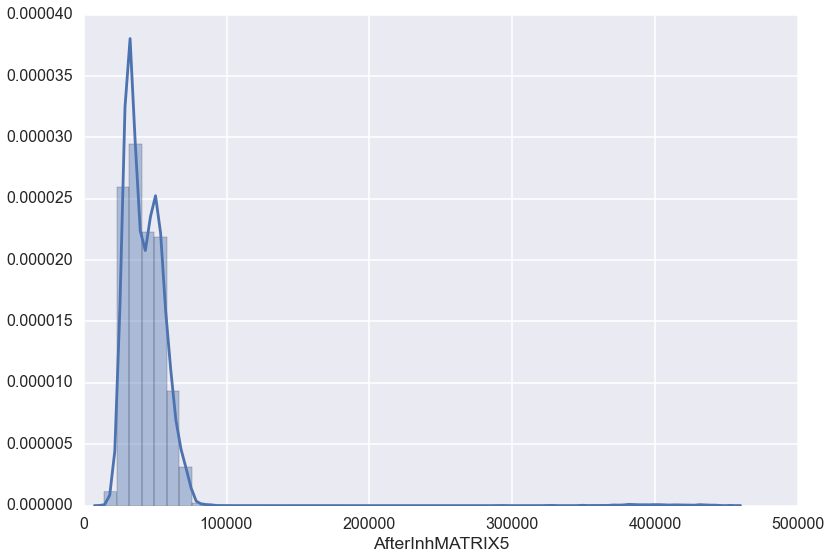

In [245]:
sns.distplot(full_df.AfterInhMATRIX5.dropna())

## Distributions affected by a very small number of outliers

In [468]:
# Remove samples where the value is outside of +/-6 standard deviations
before = len(full_df)
full_df = full_df[full_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 6).all(axis=1)]
after = len(full_df)
print "Removed %d out of %d samples as 'outliers'" % (before-after, before)

Removed 259 out of 15669 samples as 'outliers'


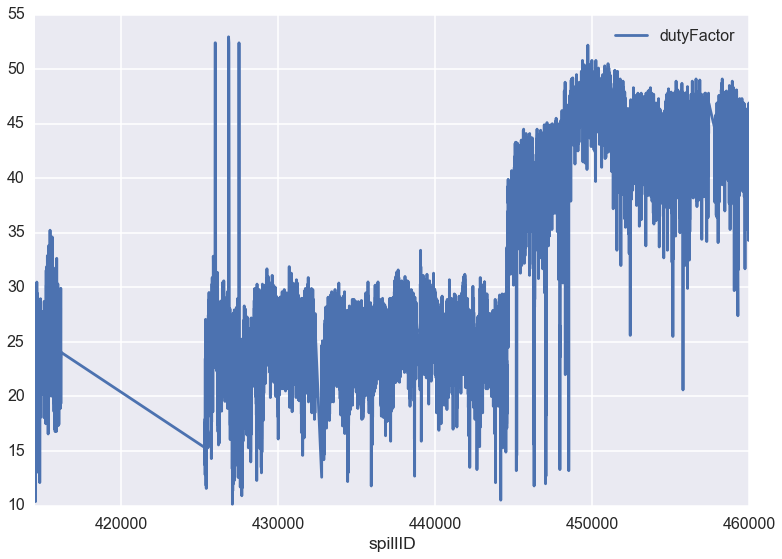

In [215]:
dutyfactor_df.sort_index(axis=0).plot()

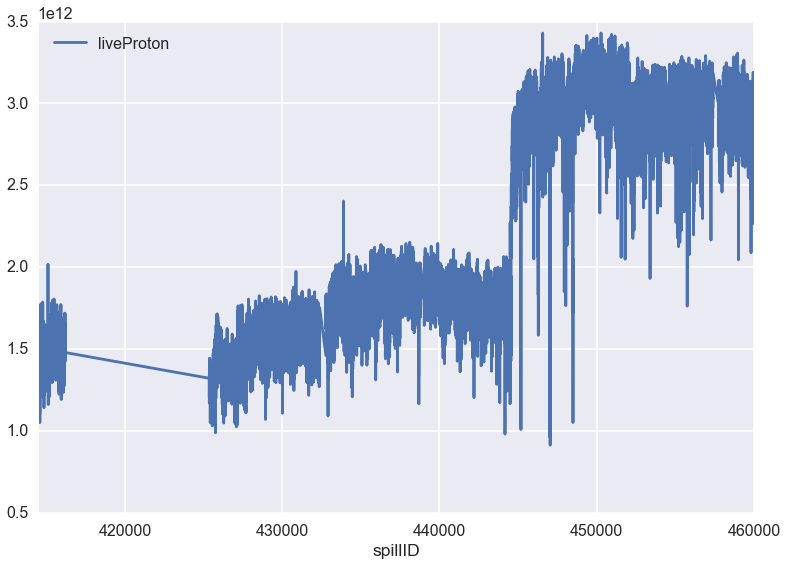

In [251]:
proton_df.sort_index(axis=0).plot()

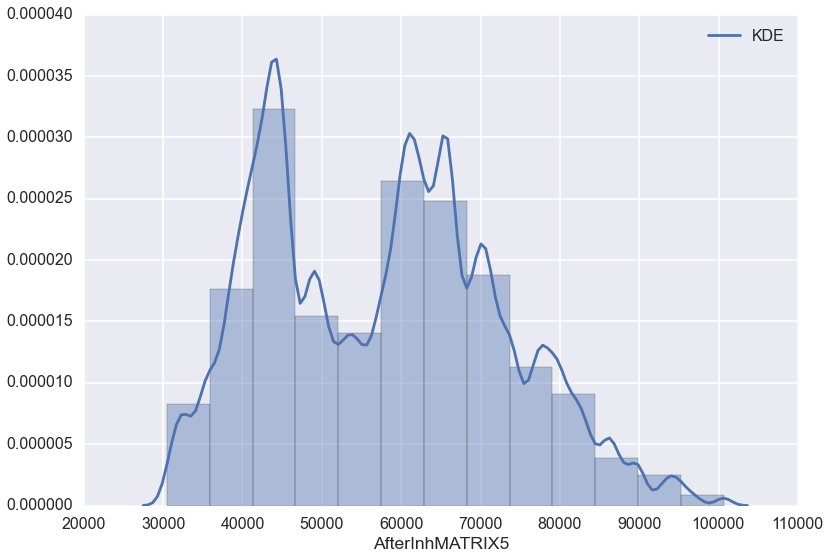

In [232]:
from scipy.stats import norm

sns.distplot(full_df.query('targetPos == 7').AfterInhMATRIX5,
             #fit=norm,
             kde_kws={"bw": 1000, "label": "KDE"},
             fit_kws={"label": "Normal"})
plt.legend(loc='best')

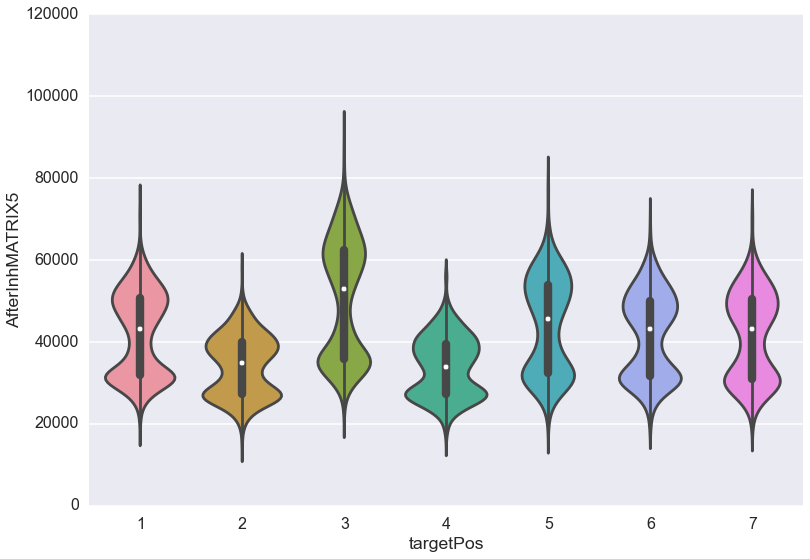

In [253]:
full_df = full_df.sort_values(by='targetPos', axis=0)
sns.violinplot(x=full_df.targetPos, y=full_df.AfterInhMATRIX5)

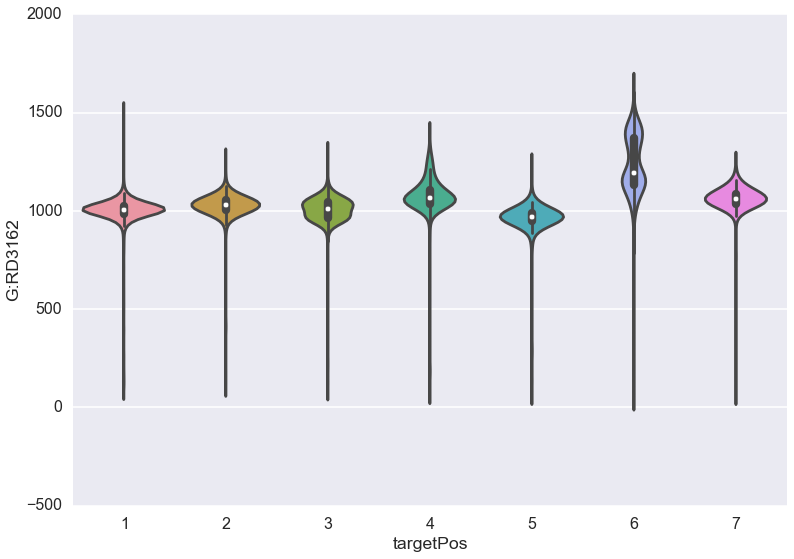

In [254]:
sns.violinplot(x=full_df.targetPos, y=full_df['G:RD3162']*100)

# Create, Train Random Forest From Data

In [255]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import cross_validation              # We'll want to cross-validate our RF
sns.set_context("poster")

In [256]:
full_df.targetPos.value_counts()

1    6743
3    3342
4    1341
6    1322
2    1319
7     673
5     670
Name: targetPos, dtype: int64

In [325]:
# Split the DataFrame up into 'data' and 'labels'
data = full_df.values[:,:-1]
labels = full_df.values[:,-1]

### Split our data up into training and test sets

In [258]:
d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data, labels, test_size=0.33, random_state=2)

### Create RFC instance

In [259]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2)

### Train on training data

In [260]:
rfc.fit(d_train, l_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [261]:
result = rfc.predict(d_test)

print("RF prediction accuracy = {0:5.1f}%".format(100.0 * rfc.score(d_test, l_test)))

RF prediction accuracy =  87.0%


### Create a Confusion histogram to examine prediction performance

In [262]:
def confusion(labels, results, names):
    plt.figure(figsize=(10, 10))
    
    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(labels.astype(int), results.astype(int), bins=len(names))

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(np.flipud(pts.astype(int)), index=np.flipud(names), columns=names )

    # Display heatmap and add decorations
    hm = sns.heatmap(pd_pts, annot=True, fmt="d", cbar=False)

    _, ylabels = plt.xticks()
    _, xlabels = plt.yticks()
    plt.setp(xlabels, rotation=45)
    plt.setp(ylabels, rotation=45)
    plt.xlabel("Actual", size=22)
    plt.ylabel("Prediction", size=22)
    
    return pts

def per_target_accuracy(hist2d_pts, names):

    for i in range(len(names)):
        rowsum = np.sum(hist2d_pts.T[i])
        if rowsum>0:
            print names[i] + ":   \t" + str(round((hist2d_pts[i][i] / np.sum(hist2d_pts.T[i]))*100,2)) + "%"
        else:
            print names[i] + ":   \tN/A"

Hydrogen:   	89.93%
Empty:   	66.88%
Deuterium:   	95.22%
None:   	70.1%
Carbon:   	92.52%
Iron:   	87.25%
Tungsten:   	82.61%


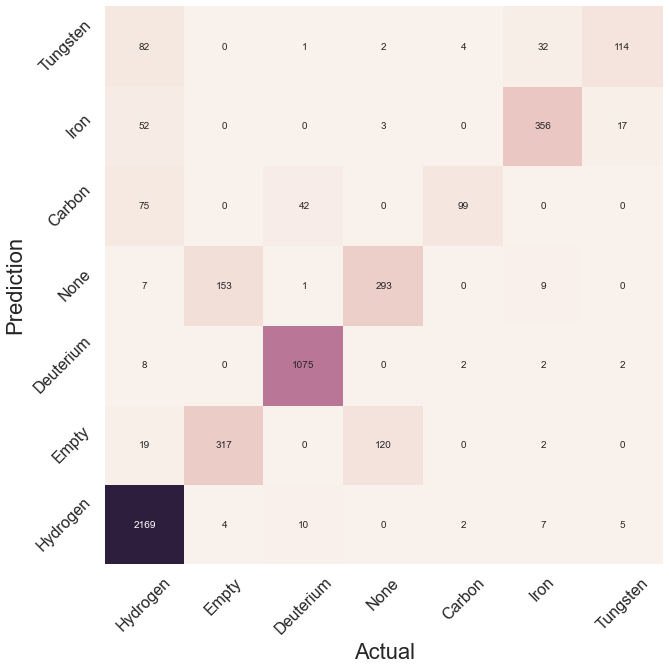

In [263]:
# Define names for the target positions
names = ['Hydrogen','Empty','Deuterium','None','Carbon','Iron','Tungsten']

pts = confusion(l_test, result, names)
per_target_accuracy(pts, names)

### Domain knowledge: "Empty" and "None" Similarity
* *"Empty"* is basically a hollow tin can
* *"None"* is no target at all
* Used to study background signals
* Will be naturally very, very similar -- and we see above that they get mistaken for each other
* We can collapse these into one category

In [264]:
def relabel(label_array):
    # Collapse target position 4 and 2 both into category 2
    # Then shift over the rest
    label_array_revised = label_array.copy()
    label_array_revised[label_array_revised == 4] = 2
    label_array_revised[label_array_revised == 5] = 4
    label_array_revised[label_array_revised == 6] = 5
    label_array_revised[label_array_revised == 7] = 6
    
    return label_array_revised

In [326]:
# Call the new re-labelling function
#    and modify the names array
labels_revised = relabel(labels)
names = ['Hydrogen','Empty/None','Deuterium','Carbon','Iron','Tungsten']

In [275]:
d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data, labels_revised, test_size=0.33, random_state=5)

rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2).fit(d_train, l_train)

result = rfc.predict(d_test)
print("RF prediction accuracy = {0:5.1f}%\n".format(100.0 * rfc.score(d_test, l_test)))

RF prediction accuracy =  92.9%



Hydrogen:   	90.1%
Empty/None:   	99.08%
Deuterium:   	95.97%
Carbon:   	93.64%
Iron:   	90.55%
Tungsten:   	84.67%


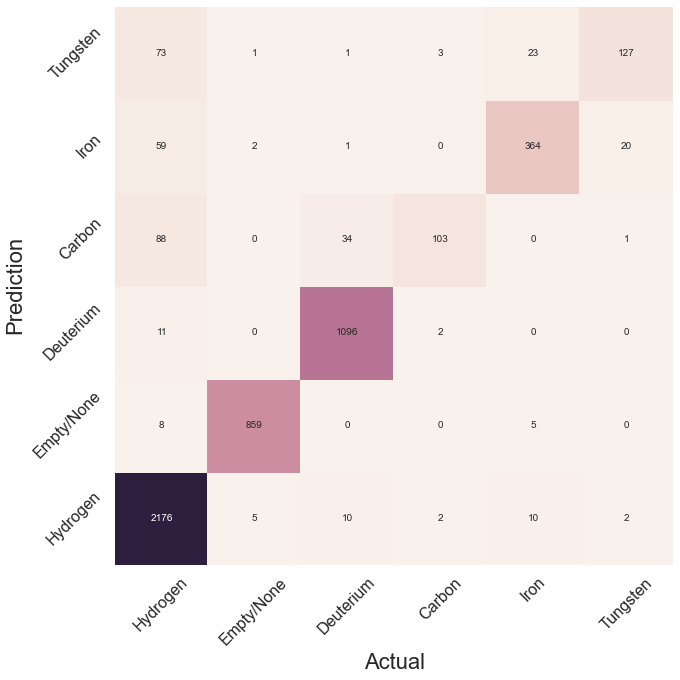

In [276]:
pts = confusion(l_test, result, names)   # Show confusion matrix
per_target_accuracy(pts, names)          # Print per-target accuracy

# Most Valuable Features
* Rank our top most valuable features
* See if any make obvious sense
* Perhaps use only useful features in future iterations

In [277]:
#features = full_df.drop(['S:G2SEM','targetPos'], axis=1).columns.values
features = full_df.drop('targetPos', axis=1).columns.values
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

useful_feature_list = []
for f in range(30):
    print("%d. Feature '%s' (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    useful_feature_list.append(features[indices[f]])

Feature ranking:
1. Feature 'G:RD3161' (0.093169)
2. Feature 'RawMATRIX4' (0.081435)
3. Feature 'G:RD3162' (0.062516)
4. Feature 'RawMATRIX5' (0.042696)
5. Feature 'PrescaledTrigger' (0.040822)
6. Feature 'RawTriggers' (0.040235)
7. Feature 'AfterInhMATRIX5' (0.036741)
8. Feature 'TsBusy' (0.030868)
9. Feature 'TSGo' (0.030115)
10. Feature 'PrescaleMATRIX5' (0.026600)
11. Feature 'PrescaleMATRIX3' (0.026229)
12. Feature 'PrescaleMATRIX1' (0.024196)
13. Feature 'AfterInhMATRIX3' (0.023416)
14. Feature 'RawMATRIX2' (0.022997)
15. Feature 'AfterInhMATRIX1' (0.022944)
16. Feature 'RawMATRIX3' (0.022330)
17. Feature 'RawMATRIX1' (0.022187)
18. Feature 'AcceptedMATRIX3' (0.021519)
19. Feature 'RawNIM1' (0.020020)
20. Feature 'AfterInhMATRIX2' (0.019978)
21. Feature 'PrescaleMATRIX2' (0.018293)
22. Feature 'RawNIM2' (0.018007)
23. Feature 'AcceptedMATRIX1' (0.017564)
24. Feature 'AcceptedMATRIX2' (0.016219)
25. Feature 'AfterInhNIM2' (0.015658)
26. Feature 'AfterInhMATRIX4' (0.015235)
27. Fea

## Train on *useful*, vetted, approved features
* Time-invariant (always been read out, always will be read out)for the experiment
* Ensures that our RFC can be used on past and future data

In [327]:
reduced_df = pd.DataFrame(full_df[useful_feature_list].values, columns=useful_feature_list )
data_reduced = reduced_df.values

RF prediction accuracy =  93.4%
Hydrogen:   	91.66%
Empty/None:   	98.88%
Deuterium:   	96.81%
Carbon:   	92.11%
Iron:   	86.73%
Tungsten:   	83.66%


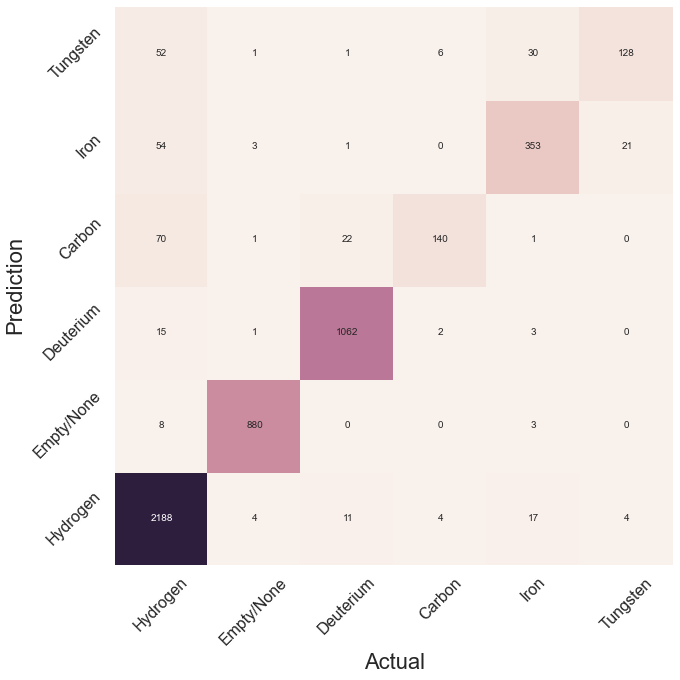

In [279]:
# We've reduced the number of features and normalized them all to beam intensity
# Let's see how that's affected our predictor

d_train, d_test, l_train, l_test \
    = cross_validation.train_test_split(data_reduced, labels_revised, test_size=0.33, random_state=6)
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2).fit(d_train, l_train)
result = rfc.predict(d_test)
print("RF prediction accuracy = {0:5.1f}%".format(100.0 * rfc.score(d_test, l_test)))

pts = confusion(l_test, result, names)
per_target_accuracy(pts, names)

# Cross-Validation
* Let us exhaustively check how robust the RFC is
* We do this by cross-validation using the whole data set
* Randomly split the data into 10 *folds* using KFold

In [293]:
from scipy.stats import mode

1.0

In [281]:
kf_total = cross_validation.StratifiedKFold(labels_revised, n_folds=10, shuffle=True, random_state=4)
rfc_scores = cross_validation.cross_val_score(rfc, data_reduced, labels_revised, cv=kf_total)

In [282]:
print "RFC Scores: ", rfc_scores
print "Accuracy: %0.2f (+/- %0.2f)" % (rfc_scores.mean(), rfc_scores.std() * 2)

RFC Scores:  [ 0.932  0.946  0.944  0.938  0.931  0.942  0.937  0.94   0.946  0.942]
Accuracy: 0.94 (+/- 0.01)


# Looks Good!
* Let's put together our official Train and Test data sets!
* We'll need to pull the data for the range of questionable target position
* We'll also need to parse apart the run log file to extract the labels

In [283]:
import re

In [328]:
# Go ahead and train the RFC using the whole, well-labelled data set
rfc = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',
                             min_samples_split=1, random_state=2).fit(data_reduced, labels_revised)

In [442]:
# Parse apart the run log file
with open('run3.log.snip','r') as f:
    log_lines = f.readlines()
match_list = []
p = re.compile("^(\d+) nominal running conditions, physics run with (\w+)")
for line in log_lines:
    if 'junk' not in line:
        m = p.match(line)
        if m:
            match_list.append(m)
run_target_dict = { m.groups()[0] : m.groups()[1] for m in match_list }

In [443]:
# Yuck! Mispellings, differet cases, symbolic terms, etc. We need to clean this up.
# Get the distinct set of names given
target_set = set()
for run, target in run_target_dict.iteritems():
    target_set.add(target)
target_set

{'C',
 'Deuterium',
 'Fe',
 'Hydrogen',
 'W',
 'carbon',
 'deuterium',
 'dueterium',
 'empty',
 'hydrogen',
 'iron',
 'no',
 'tungsten'}

In [444]:
# Create a map of these names to the target position
target_map = {'C' : 6,
              'carbon' : 6,
              'Deuterium' : 3,
              'deuterium' : 3,
              'dueterium' : 3,
              'hydrogen' : 1,
              'Hydrogen' : 1,
              'Fe' : 5,
              'iron' : 5,
              'W' : 7,
              'tungsten' : 7,
              'no' : 4,
              'empty' : 2 }
# Update the dictionary accordingly
for run, target in run_target_dict.iteritems():
    run_target_dict[run] = target_map[target]

In [445]:
run_target_dict

{'11350': 1,
 '11352': 3,
 '11353': 5,
 '11354': 1,
 '11356': 3,
 '11357': 6,
 '11358': 1,
 '11359': 3,
 '11360': 7,
 '11361': 3,
 '11362': 1,
 '11363': 2,
 '11364': 4,
 '11365': 1,
 '11366': 3,
 '11367': 5,
 '11368': 1,
 '11369': 3,
 '11370': 6,
 '11371': 1,
 '11372': 3,
 '11373': 3,
 '11374': 7,
 '11375': 1,
 '11377': 3,
 '11378': 2,
 '11379': 4,
 '11380': 1,
 '11381': 3,
 '11382': 5,
 '11383': 1,
 '11384': 3,
 '11385': 6,
 '11386': 1,
 '11387': 3,
 '11388': 7,
 '11389': 1,
 '11390': 3,
 '11391': 2,
 '11392': 4,
 '11393': 1,
 '11394': 3,
 '11395': 5,
 '11398': 1,
 '11399': 3,
 '11400': 6,
 '11401': 1,
 '11402': 3,
 '11403': 3,
 '11404': 7,
 '11405': 1,
 '11406': 3,
 '11407': 2,
 '11408': 4,
 '11409': 1,
 '11410': 3,
 '11411': 5,
 '11412': 1,
 '11413': 3,
 '11414': 6,
 '11415': 1,
 '11416': 3,
 '11417': 7,
 '11418': 1,
 '11419': 3,
 '11420': 2,
 '11421': 4,
 '11422': 1,
 '11428': 3,
 '11429': 5,
 '11430': 1,
 '11431': 3,
 '11432': 6,
 '11433': 1,
 '11435': 3,
 '11436': 7,
 '11437': 1,

In [446]:
class Run:
    
    def __init__(self, runID, noted_target, useful_features, rfc):
        self.runID = int(runID)
        self.noted_target = noted_target
        self.noted_target = self.relabel(noted_target)
        
        self.data = None
        self.predicted_target = None
        self.prediction_conf = 0.0
        
        self.data = self.get_data(useful_features)
        if self.data is not None:
            self.predicted_target, self.prediction_conf = self.predict_target(rfc)
        
    def get_spill_range(self):
        query = ("SELECT MIN(spillID), MAX(spillID) FROM Spill WHERE runID=%d" % self.runID)
        try:
            db = mdb.connect(read_default_file='../.my.cnf',
                             read_default_group='guest',
                             host=server,
                             db=schema,
                             port=port)

            cur = db.cursor()
            cur.execute(query)
            result = cur.fetchone()
            if result[0] is not None:
                (minspill, maxspill) = (int(result[0]), int(result[1]))
            else:
                return None, None
            
            if db:
                db.close()
        
        except mdb.Error, e:
            print "Error %d: %s" % (e.args[0], e.args[1])
        
        return (minspill, maxspill)
        
    def get_data(self, useful_features):
        minspill, maxspill = self.get_spill_range()
        if minspill is None:
            return None
        query = ("""SELECT spillID, name, value
                    FROM Beam b INNER JOIN Spill s USING(spillID) 
                    WHERE s.dataQuality & ~(1<<26) = 0 AND 
                          spillID BETWEEN %d AND %d AND
                          name IS NOT NULL AND
                          name!='F:NM2SEM'
                    UNION
                    SELECT spillID, scalerName as `name`, value
                    FROM Scaler b INNER JOIN Spill s USING(spillID) 
                    WHERE s.dataQuality & ~(1<<26) = 0 AND 
                          spillID BETWEEN %d AND %d AND
                          spillType = "EOS" AND
                          scalerName IS NOT NULL""" % (minspill, maxspill, minspill, maxspill))
        try:
            db = mdb.connect(read_default_file='../.my.cnf',
                             read_default_group='guest',
                             host=server,
                             db=schema,
                             port=port)

            df = pd.read_sql(query, db)
            
            if db:
                db.close()
        
        except mdb.Error, e:
            print "Error %d: %s" % (e.args[0], e.args[1])
            
        df.value = df.value.astype(float)
        pdf = df.pivot('spillID', 'name', 'value')
        del df
        pdf = pdf.replace(-9999,np.nan).dropna(axis=1)
        
        if len(pdf) > 0 and 'S:G2SEM' in pdf.columns.values:
            pdf = pdf.divide(pdf['S:G2SEM']/5.0e12, axis=0)
        else:
            return None
        
        _ = pdf.drop('S:G2SEM', axis=1, inplace=True)
        
        pdf = pdf[useful_features]
        
        data = pdf.values
        
        return data
        
    def predict_target(self, rfc):
        
        result = rfc.predict(self.data)
        result = [self.relabel(x) for x in result]
        total = float(len(result))
        
        guess = mode(result)[0][0]
        Nguess = mode(result)[1][0]
        
        confidence = float(Nguess)/total
        
        return int(guess), confidence*100.0
        
    def predict_correctly(self):
        if self.noted_target == self.predicted_target:
            return True
        else:
            return False
        
    def relabel(self, position):
        switcher = {
            1: 1,
            2: 2,
            3: 3,
            4: 2,
            5: 4,
            6: 5,
            7: 6
        }
        return switcher.get(position, None)

In [373]:
myrun = Run(run_target_dict.keys()[4], run_target_dict.values()[4], useful_feature_list, rfc)

In [447]:
l_test = []
prediction = []

for run, target in run_target_dict.iteritems():
    myrun = Run(run, target, useful_feature_list, rfc)
    if myrun.predicted_target is not None:
        if target == 4:
            l_test.append(2)
        else:
            l_test.append(target)
        prediction.append(myrun.predicted_target)
    print run, target, myrun.predicted_target, str(round(myrun.prediction_conf, 1))+'%', myrun.predict_correctly()

11380 1 1 98.2% True
11381 3 3 100.0% True
11382 5 4 96.6% True
11383 1 1 98.3% True
11384 3 3 100.0% True
11385 6 1 89.7% False
11386 1 1 100.0% True
11387 3 3 100.0% True
11388 7 4 92.9% False
11389 1 1 98.3% True
11465 3 3 100.0% True
11464 1 1 98.3% True
11466 2 1 52.9% False
11461 1 1 93.2% True
11460 6 1 78.9% False
11463 7 4 93.1% False
11462 3 3 100.0% True
11379 4 2 100.0% True
11378 2 2 100.0% True
11375 1 1 98.5% True
11374 7 4 92.3% False
11377 3 3 98.2% True
11371 1 1 95.3% True
11370 6 1 93.0% False
11373 3 3 94.7% True
11372 3 3 100.0% True
11368 1 1 100.0% True
11369 3 3 96.8% True
11366 3 3 98.3% True
11367 5 4 92.7% True
11364 4 2 100.0% True
11365 1 1 98.2% True
11362 1 1 100.0% True
11363 2 2 100.0% True
11360 7 4 100.0% False
11361 3 3 100.0% True
11443 1 1 86.4% True
11442 4 2 65.0% True
11441 2 2 100.0% True
11440 2 2 88.5% True
11447 3 3 100.0% True
11446 1 1 76.0% True
11445 5 3 94.4% False
11444 3 3 100.0% True
11449 1 1 90.2% True
11448 6 1 52.6% False
11359 

In [440]:
print l_test
print prediction

[1 3 4 1 3 5 1 3 6 1 3 1 2 1 5 6 3 2 2 1 6 3 1 5 3 3 1 3 3 4 2 1 1 2 6 3 1
 2 2 2 3 1 4 3 1 5 3 1 4 3 1 5 3 1 1 3 3 2 2 1 3 6 1 4 3 2 2 1 4 3 1 2 2 3
 1 3 5 1 1 3 6 1 3 2 3 1 6 3 3 1 5 1 2 3 4 1 3 5 1 3 6 1 3 3 1]
[1 3 4 1 3 1 1 3 4 1 3 1 1 1 1 4 3 2 2 1 4 3 1 1 3 3 1 3 3 4 2 1 1 2 4 3 1
 2 2 2 3 1 3 3 1 1 3 1 4 3 1 1 3 1 1 3 3 1 1 3 3 4 1 4 3 2 2 1 4 3 1 2 2 3
 1 3 1 1 1 3 4 1 3 2 3 1 4 3 3 1 1 1 2 3 4 1 3 1 1 3 4 1 3 3 1]


In [406]:
from sklearn.metrics import confusion_matrix

In [427]:
confusion_matrix(l_test, prediction)

array([[32,  0,  1,  0,  0,  0],
       [ 3, 13,  0,  0,  0,  0],
       [ 0,  0, 33,  0,  0,  0],
       [ 0,  0,  1,  6,  0,  0],
       [ 8,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0]])

In [399]:
names

['Hydrogen', 'Empty/None', 'Deuterium', 'Carbon', 'Iron', 'Tungsten']

In [448]:
l_test = np.array(l_test)
prediction = np.array(prediction)
l_test = relabel(l_test)